
# Project #5. Predict toxicity of chemical compounds
## 20204619 Hwang Yechan
#### Link for Google Colab : https://colab.research.google.com/drive/1s4TmlsBKAG60raTZ7gqA8sQzKu7DOHW4?usp=sharing
<br/><br/>
### 1. Install rdkit
To accomplish Project #5, first we need to install rdkit, a module that allows us to manipulate molecular structures dealing with smiles strings.
<hr/>

In [ ]:
# install rdkit library on colab environment
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-11-20 05:32:39--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-11-20 05:32:39--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   114MB/s    in 0.7s    

2020-11-20 05:32:40 (114 MB/s) - ‘Minicon

### 2. Import modules and load datasets
Then I imported basic modules for Deep Learning and rdkit.<br/>
Also I loaded data files from given datasets.
<hr/>

In [ ]:
# %matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
#import basic python packages
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase

import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.backend import one_hot
from keras.layers import Activation, Dense, Dropout, Input
from keras.utils import np_utils

In [ ]:
# load data from files
from google.colab import files
data_AR = files.upload() # select 'nr-ar.smiles' file and upload it
data_ER = files.upload() # select 'nr-er.smiels' file and upload it

Saving nr-ar.smiles to nr-ar.smiles


Saving nr-er.smiles to nr-er.smiles


### 3. Open smiles datasets
I opened 2 smiles datasets by pandas.read_csv. Smiles string informations were loaded to smi_AR and smi_ER. And their corresponding activity informations were loaded to activity_AR and activity_ER seperately. Activity value is marked as 0 when a compound is non-toxic, and 1 vice versa. 

In [ ]:
# save the uploaded data as Pandas dataframe
import io
df_AR = pd.read_csv(io.BytesIO(data_AR['nr-ar.smiles']), sep = '\t', names = ['smiles', 'array', 'activity'])
df_ER = pd.read_csv(io.BytesIO(data_ER['nr-er.smiles']), sep = '\t', names = ['smiles', 'array', 'activity'])

smi_AR = df_AR['smiles']
smi_ER = df_ER['smiles']
activity_AR = df_AR['activity']
activity_ER = df_ER['activity']

### 4. Data preprocessing : SMILES to 2048 bit Fingerprint
We need proper data shape to train Deep Learning model. Therefore our data, smiles strings, must be converted into some python recognizable form. So let's convert them to 2048 bit vectors. Converting smiles strings to 2048 bit Fingerprints are not very difficult since we can use converting function in rdkit. It is 'GetMorganFingerprintAsBitVect', which converts chemical 'Mol' object given as an argument to n-Bit vector. In order to use this function, we need to convert smiles string to Mol object first. It can be done using 'MolFromSmiles', which converts smiles strings to Mol object. But I found that some smiles strings(for example smi_AR[2168]) in our dataset failed to convert to Mol object.<br/><br/>
MolFromSmiles RETURNS: a Mol object, None on failure.<br/>
(https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html)

In [ ]:
# Some smiles data failed to convert to Mol object. 
# 'MolFromSmiles' returns 'None' when it failed to convert smiles to Mol object.
MolObject=Chem.MolFromSmiles(smi_AR[2168])
print(MolObject)

None


So before converting smiles strings through 'MolFromSmiles', I excluded some Mol unconvertible strings. Then convertible Mol objects were again converted to 2048 bit Fingerprint vector using 'GetMorganFingerprintAsBitVect'. To use that function, I set the argument 'radius' as 2 which is similar to ECFP4.<br/>
https://www.researchgate.net/post/How_to_choose_bits_and_radius_during_circular_fingerprint_calculation_in_RDKit<br/><br/>
We can adjust the length of Fingerprint vector by giving the argument 'nBits' the desired value. I set it 2048 to convert Mols to 2048 bit vecetor. After all, 2048 bits Fingerprints are converted into array using 'numpy.array'.

In [ ]:
# data preprocessing; convert SMILES string to 2048 bit Fingerprint
def preprocessing(data_X, data_Y):
    data_x=[]
    data_y=[]
    for i in range(len(data_X)):
        MolObject=Chem.MolFromSmiles(data_X[i])

        # if smiles string failed to convert to Mol object, it is ignored and the next smiles string is processed.
        if MolObject==None:
            continue
        data_x.append(AllChem.GetMorganFingerprintAsBitVect(MolObject,2,nBits=2048))
        data_y.append(data_Y[i])
    return np.array(data_x), np.array(data_y)

data_X_AR, data_Y_AR = preprocessing(smi_AR, activity_AR)
data_X_ER, data_Y_ER = preprocessing(smi_ER, activity_ER)

Using 'preprocessing' defined above, we can get array consists of 2048 bit Fingerprints and check its shape.<br/>
We can see their shape has (_,2048).

In [ ]:
# check the shape of the raw data
print(data_X_AR.shape)
print(data_Y_AR.shape)
print(data_X_ER.shape)
print(data_Y_ER.shape)

(9359, 2048)
(9359,)
(7695, 2048)
(7695,)


### 4. Split the datasets
To avoid overfitting and train properly, it is necessary to split datas into training, validation and test sets. Since we want to split the datasets in a ratio of train:validation:test=8:1:1, I splited them twice first dividing into 9:1(train+validation : test) and again them into 8:1(train : validation). After two dividing, we can get 80% training datasets(100% x 0.9 x 8/9 = 80%), 10% test datasets(100% x 0.1 = 10%) and 10% validation datasets(100 x 0.9 x 1/9=10%).<br/>To use 'train_test_split', I set 'random_state' to a random number 2. (It doesn't matter what number I put in in terms of randomness.)

In [ ]:
# split the training, validation and test dataset. train:validation:test=8:1:1
from sklearn.model_selection import train_test_split
#split training and test dataset from raw dataset

X_train_AR, X_test_AR, Y_train_AR, Y_test_AR = train_test_split(data_X_AR, data_Y_AR, test_size=0.1, random_state=2)
X_train_ER, X_test_ER, Y_train_ER, Y_test_ER = train_test_split(data_X_ER, data_Y_ER, test_size=0.1, random_state=2)

In [ ]:
#split training and validation dataset from training dataset
X_train_AR, X_valid_AR, Y_train_AR, Y_valid_AR = train_test_split(X_train_AR, Y_train_AR, test_size=1/9, random_state=2)
X_train_ER, X_valid_ER, Y_train_ER, Y_valid_ER = train_test_split(X_train_ER, Y_train_ER, test_size=1/9, random_state=2)

In [ ]:
# check the shape of the splited data
print(X_train_AR.shape, Y_train_AR.shape)
print(X_valid_AR.shape, Y_valid_AR.shape)
print(X_test_AR.shape, Y_test_AR.shape)
print(X_train_ER.shape, Y_train_ER.shape)
print(X_valid_ER.shape, Y_valid_ER.shape)
print(X_test_ER.shape, Y_test_ER.shape)

(7487, 2048) (7487,)
(936, 2048) (936,)
(936, 2048) (936,)
(6155, 2048) (6155,)
(770, 2048) (770,)
(770, 2048) (770,)


We got 8:1:1 training, validation and test sets successfully.

### 5. Build a neural network model
I built a neural network with parameters I chose by some procedures. The procedure is described at the end of this jupyter notebook file. The architecture I chose for AR is shown below.

In [ ]:
# build a neural network model
# the activation function of hidden layer is relu, and output is softmax

In [ ]:
# make a prediction model for AR
model_AR = tf.keras.models.Sequential()
model_AR.add(tf.keras.layers.Dense(32, input_shape=(2048,)))
model_AR.add(tf.keras.layers.Activation('relu'))
model_AR.add(tf.keras.layers.Dense(32))
model_AR.add(tf.keras.layers.Activation('relu'))
model_AR.add(tf.keras.layers.Dropout(0.2))
model_AR.add(tf.keras.layers.Dense(16))
model_AR.add(tf.keras.layers.Activation('relu'))
model_AR.add(tf.keras.layers.Dense(2))
model_AR.add(tf.keras.layers.Softmax())

model_AR.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_AR.summary() # print summary of AR model

Model: "sequential_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_507 (Dense)            (None, 32)                65568     
_________________________________________________________________
activation_373 (Activation)  (None, 32)                0         
_________________________________________________________________
dense_508 (Dense)            (None, 32)                1056      
_________________________________________________________________
activation_374 (Activation)  (None, 32)                0         
_________________________________________________________________
dropout_219 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_509 (Dense)            (None, 16)                528       
_________________________________________________________________
activation_375 (Activation)  (None, 16)             

Since it is binary classification, last two layers are Dense layer with 2 dimensions and Softmax activation layer. Also I chose optimizer 'adam' which performed better and learned faster than 'RMSprop'.<br/><br/>
Also the prediction model for ER is shown below.

In [ ]:
# make a prediction model for ER
model_ER = tf.keras.models.Sequential()
model_ER.add(tf.keras.layers.Dense(64, input_shape=(2048,)))
model_ER.add(tf.keras.layers.Activation('relu'))
model_ER.add(tf.keras.layers.Dropout(0.5))
model_ER.add(tf.keras.layers.Dense(32))
model_ER.add(tf.keras.layers.Activation('relu'))
model_ER.add(tf.keras.layers.Dropout(0.5))
model_ER.add(tf.keras.layers.Dense(16))
model_ER.add(tf.keras.layers.Activation('relu'))
model_ER.add(tf.keras.layers.Dense(2))
model_ER.add(tf.keras.layers.Softmax())

model_ER.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_ER.summary() # print summary of ER model

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_511 (Dense)            (None, 64)                131136    
_________________________________________________________________
activation_376 (Activation)  (None, 64)                0         
_________________________________________________________________
dropout_220 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_512 (Dense)            (None, 32)                2080      
_________________________________________________________________
activation_377 (Activation)  (None, 32)                0         
_________________________________________________________________
dropout_221 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_513 (Dense)            (None, 16)             

In order to optimize the model, we can use early stopping watching the validation accuracy.

In [ ]:
# early stopping with validation dataset 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es_AR = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_AR = ModelCheckpoint('best_model_AR.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es_ER = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_ER = ModelCheckpoint('best_model_ER.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

### 6. Train the model 
Now we are ready to train the model. We can train the model and save accuracy and loss of both training data and validation data simultaneously .

In [ ]:
# training the model using training and validation set
epochs = 50

hist_AR = model_AR.fit(X_train_AR, Y_train_AR, validation_data=(X_valid_AR, Y_valid_AR), batch_size=32, epochs=epochs, verbose=0, callbacks=[es_AR, mc_AR])


Epoch 00001: val_accuracy improved from -inf to 0.98077, saving model to best_model_AR.h5

Epoch 00002: val_accuracy improved from 0.98077 to 0.98184, saving model to best_model_AR.h5

Epoch 00003: val_accuracy improved from 0.98184 to 0.98291, saving model to best_model_AR.h5

Epoch 00004: val_accuracy did not improve from 0.98291

Epoch 00005: val_accuracy did not improve from 0.98291

Epoch 00006: val_accuracy did not improve from 0.98291

Epoch 00007: val_accuracy did not improve from 0.98291
Epoch 00007: early stopping


In [ ]:
hist_ER = model_ER.fit(X_train_ER, Y_train_ER, validation_data=(X_valid_ER, Y_valid_ER),batch_size=32, epochs=epochs, verbose=0, callbacks=[es_ER, mc_ER])


Epoch 00001: val_accuracy improved from -inf to 0.87662, saving model to best_model_ER.h5

Epoch 00002: val_accuracy did not improve from 0.87662

Epoch 00003: val_accuracy improved from 0.87662 to 0.89221, saving model to best_model_ER.h5

Epoch 00004: val_accuracy improved from 0.89221 to 0.89740, saving model to best_model_ER.h5

Epoch 00005: val_accuracy improved from 0.89740 to 0.90390, saving model to best_model_ER.h5

Epoch 00006: val_accuracy improved from 0.90390 to 0.90649, saving model to best_model_ER.h5

Epoch 00007: val_accuracy did not improve from 0.90649

Epoch 00008: val_accuracy did not improve from 0.90649

Epoch 00009: val_accuracy did not improve from 0.90649
Epoch 00009: early stopping


### 7. Visualize accuracy and loss
With the stored accuracy and loss in hist_AR and hist_ER, we can visualize them using matplotlib. The code for visualizing the accuracy and loss according to epoch for model_AR and its result is shown below. And at the left plot, we can see that accuracy for training data decreases after epoch 2 while accuracy for validation data keep increases. At the right plot, we can see that validation loss decreases. By the two plots, we can check that our model is not overfitted.

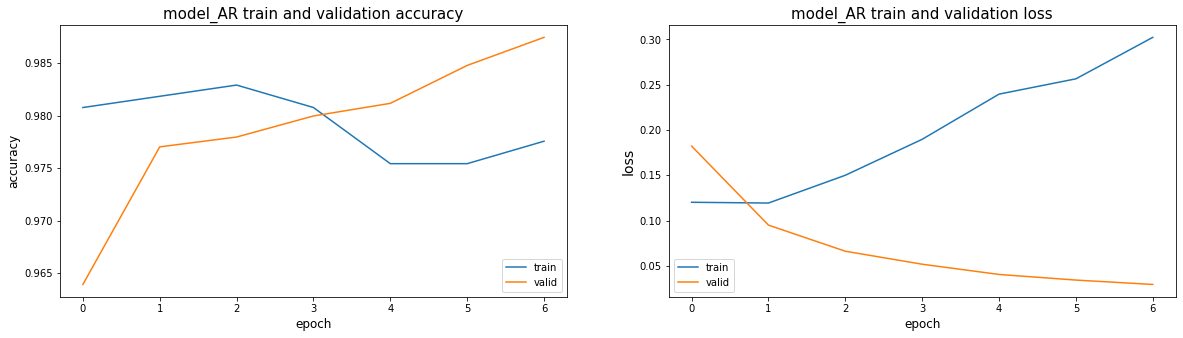

In [ ]:
# plot the accuracy and loss value of each model.

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(hist_AR.history['val_accuracy'])
plt.plot(hist_AR.history['accuracy'])
plt.title('model_AR train and validation accuracy',fontsize=15)
plt.ylabel('accuracy',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'valid'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist_AR.history['val_loss'])
plt.plot(hist_AR.history['loss'])
plt.title('model_AR train and validation loss',fontsize=15)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'valid'], loc='lower left')
plt.show()

We can do the same procedure for model_ER too. The shape of the graphs are similar to the graphs in plots above. This also shows that the model is not overfitted.<br/>
model_AR tends to finish learning earlier than model_AR since the difference of the quantity of training data and number of trainable parameters.

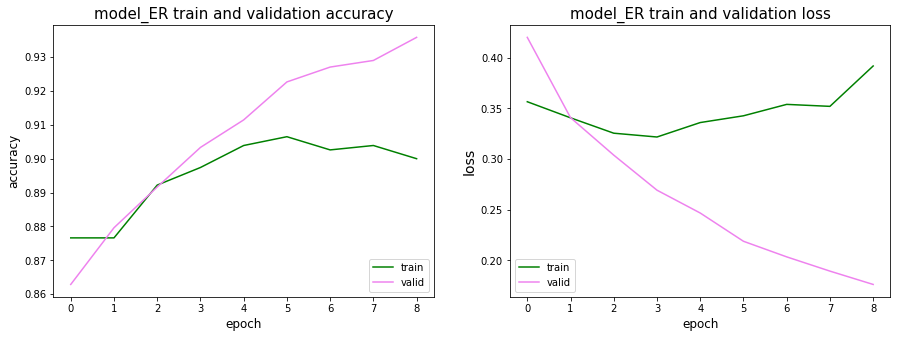

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(hist_ER.history['val_accuracy'],color='green')
plt.plot(hist_ER.history['accuracy'],color='violet')
plt.title('model_ER train and validation accuracy',fontsize=15)
plt.ylabel('accuracy',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'valid'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist_ER.history['val_loss'],color='green')
plt.plot(hist_ER.history['loss'],color='violet')
plt.title('model_ER train and validation loss',fontsize=15)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'valid'], loc='lower left')
plt.show()

### 8. Evaluate the prediction model
Finally, let's evaluate our two models using test datasets. First we can evaluate the models by using 'classification_report'. Since I made models determining the toxicity of Mols, I set the target_names as 'non-toxic' and 'toxic'. Then using the predicted classes, we can check some performances such as precision, recall, etc. Predicted class will be 1 if model's predicted probability for 1(toxic) is larger than 0(non-toxic).

In [ ]:
# evaluate the prediction model using test dataset.
from sklearn.metrics import classification_report, roc_curve, auc

Y_true_AR=Y_test_AR
Y_pred_AR=model_AR.predict_classes(X_test_AR)

target_names = ['non-toxic', 'toxic']
print(classification_report(Y_true_AR, Y_pred_AR, target_names=target_names))

              precision    recall  f1-score   support

   non-toxic       0.99      1.00      0.99       901
       toxic       0.87      0.74      0.80        35

    accuracy                           0.99       936
   macro avg       0.93      0.87      0.90       936
weighted avg       0.99      0.99      0.99       936



In [ ]:
score_AR = model_AR.evaluate(X_test_AR, Y_test_AR, verbose=2)

30/30 - 0s - loss: 0.1691 - accuracy: 0.9861


Also, the test score for model_AR is shown above. It has a very high accuracy over 98%.<br/>
For model_ER, we can see some performances and test score as well.

In [ ]:

Y_true_ER=Y_test_ER
Y_pred_ER=model_ER.predict_classes(X_test_ER)

target_names = ['non-toxic', 'toxic']
print(classification_report(Y_true_ER, Y_pred_ER, target_names=target_names))

              precision    recall  f1-score   support

   non-toxic       0.92      0.99      0.95       674
       toxic       0.80      0.43      0.56        96

    accuracy                           0.92       770
   macro avg       0.86      0.71      0.76       770
weighted avg       0.91      0.92      0.90       770



In [ ]:
score_ER = model_ER.evaluate(X_test_ER, Y_test_ER, verbose=2)

25/25 - 0s - loss: 0.3876 - accuracy: 0.9156


This time, let's check the ROC curve and AUC of both models. Here fpr is 'False positive rates' for each possible threshold and tpr is 'True positive rates' for each possible threshold. We must give the true labels of test datasets and the predicted probabilities for the 1 class to the 'roc_curve' to calculate fpr, tpr and thresholds. (The predicted probabilities for the 1 class is second element of predicted output.) Then using fpr and tpr, we can get AUC of model_AR by using 'auc' in sklearn.

In [ ]:
# AUC of AR dataset
Y_pred_AR = model_AR.predict(X_test_AR)
fpr_AR, tpr_AR, thresholds_AR = roc_curve(Y_test_AR, Y_pred_AR[:,1])
auc_AR = auc(fpr_AR, tpr_AR)
print(auc_AR)

0.8308863167908673


AUC for model_AR is about 0.8309. Now let's draw ROC curve of model_AR.

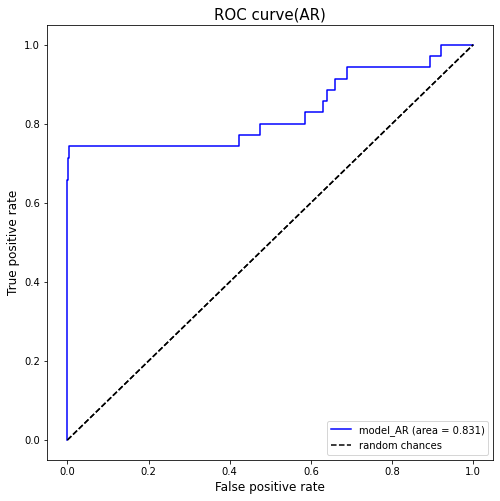

In [ ]:
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_AR, tpr_AR, label='model_AR (area = {:.3f})'.format(auc_AR),color='blue')
plt.plot([0,1],[0,1],label='random chances',linestyle='dashed',color='black')
plt.xlabel('False positive rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.title('ROC curve(AR)',fontsize=15)
plt.legend(loc='lower right')
plt.show()

Now let's do the same procedure for model_ER. As expected by the performances such as test score and precisions, model_AR has larger AUC and good shape of ROC curve.<br/>
Finally, I drew the two ROC curves overlapping and finished the project.

0.7002117334322453


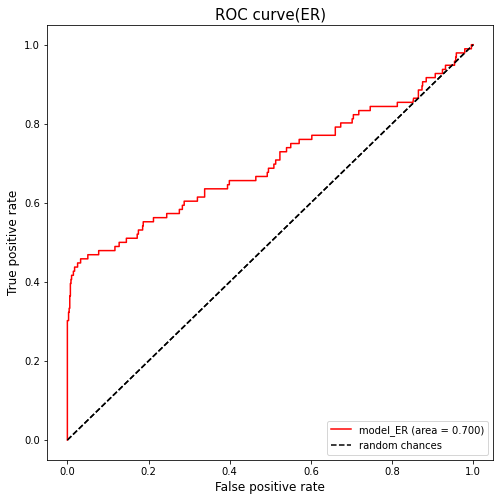

In [ ]:
# AUC of ER dataset
Y_pred_ER = model_ER.predict(X_test_ER)
fpr_ER, tpr_ER, thresholds_ER = roc_curve(Y_test_ER, Y_pred_ER[:,1])
auc_ER = auc(fpr_ER, tpr_ER)
print(auc_ER)

plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ER, tpr_ER, label='model_ER (area = {:.3f})'.format(auc_ER),color='red')
plt.plot([0,1],[0,1],label='random chances',linestyle='dashed',color='black')
plt.xlabel('False positive rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.title('ROC curve(ER)',fontsize=15)
plt.legend(loc='lower right')
plt.show()

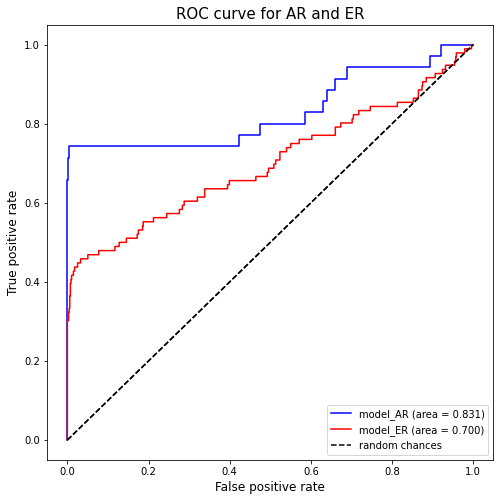

In [ ]:
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_AR, tpr_AR, label='model_AR (area = {:.3f})'.format(auc_AR),color='blue')
plt.plot(fpr_ER, tpr_ER, label='model_ER (area = {:.3f})'.format(auc_ER),color='red')
plt.plot([0,1],[0,1],label='random chances',linestyle='dashed',color='black')
plt.xlabel('False positive rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.title('ROC curve for AR and ER',fontsize=15)
plt.legend(loc='lower right')
plt.show()

<br/><br/><br/><br/><br/><br/><br/>
### (Before running : The code below takes very long time. I do not recommend to run it to see the result.)
<hr/>

### Appendix: How did I optimize the parameters?
To optimize the parameters and architectures, I used some kind of making combinations of layers. I set some rules for architecture.<br/>


1. Number of layer is 1,2 or 3.
2. Each layer can have dimension among 16, 32, 64, 128, 256, 512 and 1024.
3. After dense layer, activation layer(relu) is added.
4. Dropout layer can be added with prob=0.2, 0.5 or not.
5. Last two layers are dense layer with dimension 2 and Softmax.
6. Deeper layer cannot have more dimensions that upper layer.

With these rules, I made code to implement them. I used same 'EarlyStopping' which is given in the pseudo code.<br/>
So there are total 2541 candidate architectures. Using all these architectures with two optimizer(adam and RMSprop), I trained them parallelly in different colab servers and then copied them. It took really much time. At the last part of this jupyter file, there are results of each architectures.



In [ ]:
LayerNum=[16,32,64,128,256,512,1024]
DropoutProb=[0,0.2,0.5]

LinearModelList=[]
ArchitectureList=[]

epochs = 50

# early stopping with validation dataset 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es_AR = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc_AR = ModelCheckpoint('best_model_AR.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
es_ER = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc_ER = ModelCheckpoint('best_model_ER.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

for LayerNumElement in LayerNum:
    for DropoutProbElement in DropoutProb:
        ArchitectureList.append([LayerNumElement,DropoutProbElement])
        LinearModelList.append([LayerNumElement,DropoutProbElement])

LinearModelList,len(LinearModelList)

([[16, 0],
  [16, 0.2],
  [16, 0.5],
  [32, 0],
  [32, 0.2],
  [32, 0.5],
  [64, 0],
  [64, 0.2],
  [64, 0.5],
  [128, 0],
  [128, 0.2],
  [128, 0.5],
  [256, 0],
  [256, 0.2],
  [256, 0.5],
  [512, 0],
  [512, 0.2],
  [512, 0.5],
  [1024, 0],
  [1024, 0.2],
  [1024, 0.5]],
 21)

In [ ]:
ModelIndex=[0,21]
for layer in range(2):
    LinearModelListLen=len(LinearModelList)
    for modelIndex in range(ModelIndex[layer],LinearModelListLen):
        for ArchitectureListElement in ArchitectureList:
            NewLinearModel=LinearModelList[modelIndex].copy()
            NewLinearModel.extend(ArchitectureListElement)
            if NewLinearModel[2*layer]>=NewLinearModel[2*(layer+1)]:
                LinearModelList.append(NewLinearModel)

len(LinearModelList)

2541

In [ ]:
bestModel_AR=''
bestScore_AR=0
bestOptimizer_AR=''

es_AR = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc_AR = ModelCheckpoint('best_model_AR.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

for LinearModelIndex in range(len(LinearModelList)):
    model_AR = tf.keras.models.Sequential()
    for architecture in range(0,len(LinearModelList[LinearModelIndex]),2):
        LayerNodeNum,DropOutProb = LinearModelList[LinearModelIndex][architecture:architecture+2]
        if architecture==0:
            model_AR.add(tf.keras.layers.Dense(LayerNodeNum, input_shape=(2048,)))
        else:
            model_AR.add(tf.keras.layers.Dense(LayerNodeNum))
        model_AR.add(tf.keras.layers.Activation('relu'))
        if DropOutProb!=0:
            model_AR.add(tf.keras.layers.Dropout(DropOutProb))
    model_AR.add(tf.keras.layers.Dense(2))
    model_AR.add(tf.keras.layers.Softmax())

    model_AR.compile(optimizer='RMSprop',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
    model_AR.fit(X_train_AR, Y_train_AR, validation_data=(X_valid_AR, Y_valid_AR), batch_size=32, epochs=epochs, verbose=0, callbacks=[es_AR, mc_AR])
    print("model : "+str(LinearModelList[LinearModelIndex]))
    score_AR = model_AR.evaluate(X_test_AR, Y_test_AR, verbose=2)
    print(score_AR)
    print()
    if bestScore_AR<score_AR[1]:
        bestScore_AR=score_AR[1]
        bestModel_AR=LinearModelList[LinearModelIndex]
        bestOptimizer_AR='RMSprop'

print("best model_AR with RMSprop is :"+str(bestModel_AR))
print(bestScore_AR)

In [ ]:
bestModel_AR=''
bestScore_AR=0
bestOptimizer_AR=''

es_AR = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc_AR = ModelCheckpoint('best_model_AR.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

for LinearModelIndex in range(len(LinearModelList)):
    model_AR = tf.keras.models.Sequential()
    for architecture in range(0,len(LinearModelList[LinearModelIndex]),2):
        LayerNodeNum,DropOutProb = LinearModelList[LinearModelIndex][architecture:architecture+2]
        if architecture==0:
            model_AR.add(tf.keras.layers.Dense(LayerNodeNum, input_shape=(2048,)))
        else:
            model_AR.add(tf.keras.layers.Dense(LayerNodeNum))
        model_AR.add(tf.keras.layers.Activation('relu'))
        if DropOutProb!=0:
            model_AR.add(tf.keras.layers.Dropout(DropOutProb))
    model_AR.add(tf.keras.layers.Dense(2))
    model_AR.add(tf.keras.layers.Softmax())

    model_AR.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
    model_AR.fit(X_train_AR, Y_train_AR, validation_data=(X_valid_AR, Y_valid_AR), batch_size=32, epochs=epochs, verbose=0, callbacks=[es_AR, mc_AR])
    print("model : "+str(LinearModelList[LinearModelIndex]))
    score_AR = model_AR.evaluate(X_test_AR, Y_test_AR, verbose=2)
    print(score_AR)
    print()
    if bestScore_AR<score_AR[1]:
        bestScore_AR=score_AR[1]
        bestModel_AR=LinearModelList[LinearModelIndex]
        bestOptimizer_AR='adam'

print("best model_AR with adam is :"+str(bestModel_AR))
print(bestScore_AR)

In [ ]:
bestModel_ER=''
bestScore_ER=0
bestOptimizer_ER=''

es_ER = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc_ER = ModelCheckpoint('best_model_ER.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

for LinearModelIndex in range(len(LinearModelList)):
    model_ER = tf.keras.models.Sequential()
    for architecture in range(0,len(LinearModelList[LinearModelIndex]),2):
        LayerNodeNum,DropOutProb = LinearModelList[LinearModelIndex][architecture:architecture+2]
        if architecture==0:
            model_ER.add(tf.keras.layers.Dense(LayerNodeNum, input_shape=(2048,)))
        else:
            model_ER.add(tf.keras.layers.Dense(LayerNodeNum))
        model_ER.add(tf.keras.layers.Activation('relu'))
        if DropOutProb!=0:
            model_ER.add(tf.keras.layers.Dropout(DropOutProb))
    model_ER.add(tf.keras.layers.Dense(2))
    model_ER.add(tf.keras.layers.Softmax())

    model_ER.compile(optimizer='RMSprop',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
    model_ER.fit(X_train_ER, Y_train_ER, validation_data=(X_valid_ER, Y_valid_ER), batch_size=32, epochs=epochs, verbose=0, callbacks=[es_ER, mc_ER])
    print("model : "+str(LinearModelList[LinearModelIndex]))
    score_ER = model_ER.evaluate(X_test_ER, Y_test_ER, verbose=2)
    print(score_ER)
    print()
    if bestScore_ER<score_ER[1]:
        bestScore_ER=score_ER[1]
        bestModel_ER=LinearModelList[LinearModelIndex]
        bestOptimizer_ER='RMSprop'

print("best model_ER with RMSprop is :"+str(bestModel_AR))
print(bestScore_AR)

In [ ]:
bestModel_ER=''
bestScore_ER=0
bestOptimizer_ER=''

es_ER = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
mc_ER = ModelCheckpoint('best_model_ER.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

for LinearModelIndex in range(len(LinearModelList)):
    model_ER = tf.keras.models.Sequential()
    for architecture in range(0,len(LinearModelList[LinearModelIndex]),2):
        LayerNodeNum,DropOutProb = LinearModelList[LinearModelIndex][architecture:architecture+2]
        if architecture==0:
            model_ER.add(tf.keras.layers.Dense(LayerNodeNum, input_shape=(2048,)))
        else:
            model_ER.add(tf.keras.layers.Dense(LayerNodeNum))
        model_ER.add(tf.keras.layers.Activation('relu'))
        if DropOutProb!=0:
            model_ER.add(tf.keras.layers.Dropout(DropOutProb))
    model_ER.add(tf.keras.layers.Dense(2))
    model_ER.add(tf.keras.layers.Softmax())

    model_ER.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
    model_ER.fit(X_train_ER, Y_train_ER, validation_data=(X_valid_ER, Y_valid_ER), batch_size=32, epochs=epochs, verbose=0, callbacks=[es_ER, mc_ER])
    print("model : "+str(LinearModelList[LinearModelIndex]))
    score_ER = model_ER.evaluate(X_test_ER, Y_test_ER, verbose=2)
    print(score_ER)
    print()
    if bestScore_ER<score_ER[1]:
        bestScore_ER=score_ER[1]
        bestModel_ER=LinearModelList[LinearModelIndex]
        bestOptimizer_ER='adam'

print("best model_ER with adam is :"+str(bestModel_AR))
print(bestScore_AR)

best model_AR with RMSprop is :[512, 0, 16, 0, 16, 0]<br/>
0.9893162250518799<br/><br/>

best model_AR with adam is :[64, 0, 64, 0.2, 64, 0]<br/>
0.9903846383094788<br/><br/>

best model_AR with RMSprop is :[512, 0.2, 16, 0.2]<br/>
0.9116883277893066<br/><br/>

best model_ER with adam is :[64, 0.5, 32, 0.5, 16, 0]<br/>
0.916883111000061


<hr/>
The results are shown above, which have very good performances. But since the initializing problem of parameters, the best architectures didn't perform same as the results shown above. If I saved the models and imported them, they would perform with same accuracy.